In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
pdata = pd.read_csv("./t2_generated.csv")


In [3]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, 1, N_SOLUTIONS)



coords = np.array([pdata.x , pdata.y]).T
deflection_x = np.array(pdata.u_x)
deflection_y = np.array(pdata.u_y)
boundary = np.array(pdata.boundary)

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=10
condition_outside = (distances2d>10) * (distances2d<=CUTOFF+10)

del distances2d, mask, boundary2d
gc.collect()



0

In [4]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)


Size of the problem is 5183


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:

obs_x_in = deflection_x[condition_inside]
obs_x_out = deflection_x[condition_outside]

obs_y_in = deflection_y[condition_inside]
obs_y_out = deflection_y[condition_outside]

n_in = len(x_in)
n_out = len(x_out)


gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma = Variable(n_in,2)
predicted_in_x = G_in_in_xx * sigma[:,0] + G_in_in_xy * sigma[:,1]
predicted_out_x = G_out_in_xx * sigma[:,0] + G_out_in_xy * sigma[:,1]
predicted_in_y = G_in_in_yx * sigma[:,0] + G_in_in_yy * sigma[:,1]
predicted_out_y = G_out_in_yx * sigma[:,0] + G_out_in_yy * sigma[:,1]

error = sum_squares(obs_x_in - predicted_in_x) + sum_squares(obs_x_out - predicted_out_x) #+ \
#    sum_squares(obs_y_in - predicted_in_y) + sum_squares(obs_y_out - predicted_out_y)

forceconstraints = [sum_entries(sigma[:,0])==0, sum_entries(sigma[:,1])==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma[:,1]) - mul_elemwise(y_in-y_center,sigma[:,0]))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [6]:
regularity_penalty = sum_entries(pnorm(sigma,2, axis=1))
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_values = []

u_x_values = []


In [7]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_values.append(sigma.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma[:,0].value.reshape((n_in,))
    s_y[condition_inside].flat = sigma[:,1].value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma[:,0].value, sigma[:,1].value]).T, error.value, regularity_penalty.value, val

    return np.array([s_x, s_y]).T,  error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
pad_results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  1e+01  4e+01  1e+00
 1:  1.2889e-01  2.1018e-02  1e+02  9e-01  3e+00  1e-01
 2:  7.1339e-02  2.7687e-02  1e+01  2e-01  6e-01  6e-03
 3:  2.4128e-02  2.3767e-02  1e-01  2e-02  7e-02  5e-03
 4:  2.2075e-02  2.1460e-02  2e-02  5e-03  2e-02  8e-04
 5:  2.0356e-02  2.0246e-02  4e-03  2e-03  7e-03  5e-04
 6:  1.9716e-02  1.9714e-02  8e-04  6e-04  2e-03  2e-04
 7:  1.9609e-02  1.9607e-02  2e-04  2e-04  6e-04  5e-05
 8:  1.9603e-02  1.9600e-02  2e-04  2e-04  5e-04  4e-05
 9:  1.9571e-02  1.9570e-02  5e-05  4e-05  1e-04  9e-06
10:  1.9564e-02  1.9563e-02  1e-05  1e-05  3e-05  2e-06
11:  1.9562e-02  1.9562e-02  3e-06  2e-06  7e-06  5e-07
12:  1.9561e-02  1.9561e-02  6e-07  5e-07  2e-06  1e-07
13:  1.9561e-02  1.9561e-02  1e-07  9e-08  3e-07  2e-08
14:  1.9561e-02  1.9561e-02  2e-08  1e-08  5e-08  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00 

 9:  2.3077e-02  2.3079e-02  7e-05  7e-05  2e-04  2e-05
10:  2.3072e-02  2.3071e-02  4e-05  3e-05  1e-04  8e-06
11:  2.3066e-02  2.3065e-02  1e-05  1e-05  3e-05  2e-06
12:  2.3063e-02  2.3063e-02  2e-06  2e-06  5e-06  3e-07
13:  2.3063e-02  2.3063e-02  4e-07  3e-07  1e-06  6e-08
14:  2.3063e-02  2.3063e-02  3e-08  2e-08  7e-08  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  1e+01  4e+01  1e+00
 1:  2.8031e-01  3.8568e-02  2e+02  2e+00  6e+00  2e-01
 2:  7.5606e-02  4.6375e-02  3e+00  2e-01  6e-01  2e-02
 3:  2.8001e-02  3.0802e-02  6e-02  2e-02  8e-02  9e-03
 4:  2.5864e-02  2.8158e-02  3e-02  2e-02  5e-02  7e-03
 5:  2.4280e-02  2.6578e-02  2e-02  1e-02  4e-02  6e-03
 6:  2.4447e-02  2.4718e-02  3e-03  3e-03  9e-03  1e-03
 7:  2.4040e-02  2.4108e-02  8e-04  7e-04  2e-03  3e-04
 8:  2.4027e-02  2.4069e-02  6e-04  6e-04  2e-03  2e-04
 9:  2.3945e-02  2.3954e-02  1e-04  1e-04  4e-04  5e-05
10:  2.3944e-02  2.3950e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  1e+01  4e+01  1e+00
 1:  4.5253e-02 -7.3025e-02  1e+02  2e+00  7e+00  5e-01
 2:  9.4955e-02  6.8052e-02  4e+00  3e-01  1e+00  7e-02
 3:  3.5519e-02  5.0058e-02  4e-01  1e-01  3e-01  4e-02
 4:  4.2654e-02  4.4113e-02  4e-02  2e-02  7e-02  7e-03
 5:  3.8401e-02  4.0720e-02  2e-02  1e-02  4e-02  5e-03
 6:  3.9420e-02  3.9935e-02  3e-03  3e-03  8e-03  1e-03
 7:  3.9669e-02  3.9814e-02  1e-03  8e-04  3e-03  4e-04
 8:  3.9741e-02  3.9785e-02  6e-04  5e-04  2e-03  2e-04
 9:  3.9749e-02  3.9754e-02  9e-05  6e-05  2e-04  2e-05
10:  3.9749e-02  3.9749e-02  3e-05  2e-05  6e-05  5e-06
11:  3.9748e-02  3.9748e-02  6e-06  4e-06  1e-05  1e-06
12:  3.9748e-02  3.9748e-02  1e-06  9e-07  3e-06  2e-07
13:  3.9747e-02  3.9747e-02  8e-08  5e-08  2e-07  1e-08
14:  3.9747e-02  3.9747e-02  4e-09  3e-09  9e-09  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00 

11:  1.0134e-01  1.0136e-01  9e-05  4e-05  1e-04  3e-05
12:  1.0136e-01  1.0137e-01  2e-05  8e-06  3e-05  7e-06
13:  1.0137e-01  1.0137e-01  1e-06  5e-07  2e-06  4e-07
14:  1.0137e-01  1.0137e-01  2e-07  8e-08  2e-07  6e-08
15:  1.0137e-01  1.0137e-01  5e-08  2e-08  5e-08  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  1e+01  3e+01  1e+00
 1: -6.2417e-01 -1.7309e-01  3e+01  1e+00  3e+00  8e-01
 2: -1.2235e-01  4.2481e-02  9e-01  2e-01  5e-01  2e-01
 3:  4.4780e-02  9.3297e-02  2e-01  5e-02  1e-01  6e-02
 4:  3.7912e-02  9.1325e-02  2e-01  5e-02  2e-01  7e-02
 5:  9.2015e-02  1.0881e-01  4e-02  2e-02  5e-02  2e-02
 6:  9.2009e-02  1.0853e-01  5e-02  2e-02  5e-02  2e-02
 7:  1.1083e-01  1.1457e-01  1e-02  4e-03  1e-02  5e-03
 8:  1.1486e-01  1.1585e-01  3e-03  1e-03  3e-03  1e-03
 9:  1.1568e-01  1.1608e-01  2e-03  6e-04  2e-03  6e-04
10:  1.1630e-01  1.1634e-01  2e-04  6e-05  2e-04  5e-05
11:  1.1636e-01  1.1636e-0

 4:  2.3377e-01  2.8443e-01  3e-01  3e-02  4e-02  6e-02
 5:  2.3037e-01  2.8329e-01  4e-01  3e-02  5e-02  6e-02
 6:  3.2429e-01  3.3859e-01  1e-01  8e-03  1e-02  2e-02
 7:  3.2857e-01  3.4082e-01  1e-01  8e-03  1e-02  1e-02
 8:  3.5293e-01  3.5608e-01  2e-02  2e-03  3e-03  4e-03
 9:  3.5776e-01  3.5884e-01  1e-02  9e-04  1e-03  1e-03
10:  3.6086e-01  3.6097e-01  1e-03  1e-04  2e-04  1e-04
11:  3.6119e-01  3.6121e-01  3e-04  2e-05  3e-05  3e-05
12:  3.6124e-01  3.6124e-01  7e-05  5e-06  8e-06  6e-06
13:  3.6125e-01  3.6125e-01  2e-05  1e-06  2e-06  1e-06
14:  3.6126e-01  3.6126e-01  2e-06  1e-07  2e-07  1e-07
15:  3.6126e-01  3.6126e-01  2e-07  1e-08  2e-08  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  1e+01  2e+01  1e+00
 1: -1.1255e+01 -4.9358e+00  2e+01  1e+00  2e+00  7e+00
 2: -2.7328e-01  4.2427e-02  2e+00  1e-01  1e-01  3e-01
 3: -1.6454e-01  1.0915e-01  1e+00  9e-02  1e-01  3e-01
 4:  2.2529e-01  3.0857e-0

 1: -2.5281e+01 -1.1126e+01  7e+02  5e+00  2e+00  2e+01
 2: -2.0302e+01 -5.3631e+00  2e+01  5e-01  2e-01  2e+01
 3: -2.3633e+00 -1.0264e-01  3e+00  8e-02  3e-02  2e+00
 4:  9.9632e-02  8.0426e-01  1e+00  3e-02  9e-03  7e-01
 5:  1.0694e-01  8.0001e-01  1e+00  3e-02  1e-02  7e-01
 6:  9.4910e-01  1.1108e+00  3e-01  7e-03  2e-03  2e-01
 7:  1.0617e+00  1.1444e+00  2e-01  4e-03  1e-03  8e-02
 8:  1.1491e+00  1.1767e+00  6e-02  1e-03  5e-04  3e-02
 9:  1.1669e+00  1.1815e+00  5e-02  9e-04  3e-04  1e-02
10:  1.1876e+00  1.1905e+00  9e-03  2e-04  6e-05  3e-03
11:  1.1921e+00  1.1924e+00  9e-04  2e-05  6e-06  3e-04
12:  1.1925e+00  1.1925e+00  1e-04  2e-06  8e-07  3e-05
13:  1.1926e+00  1.1926e+00  7e-06  1e-07  5e-08  2e-06
14:  1.1926e+00  1.1926e+00  3e-07  6e-09  2e-09  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  4e+03  1e+01  3e+00  1e+00
 1: -1.4844e+01 -6.4202e+00  5e+02  3e+00  1e+00  9e+00
 2: -7.3627e+00 -1.8458e+0

 2:  5.3325e-01  7.5601e-01  9e+01  3e-01  3e-02  3e-01
 3:  4.9476e-01  7.2172e-01  1e+02  4e-01  3e-02  3e-01
 4:  1.5130e+00  1.5576e+00  2e+01  9e-02  7e-03  7e-02
 5:  2.0243e+00  2.0464e+00  1e+01  5e-02  4e-03  4e-02
 6:  2.4453e+00  2.4574e+00  8e+00  3e-02  2e-03  2e-02
 7:  2.7150e+00  2.7202e+00  4e+00  1e-02  1e-03  9e-03
 8:  2.7232e+00  2.7282e+00  4e+00  2e-02  1e-03  9e-03
 9:  2.8458e+00  2.8484e+00  2e+00  8e-03  7e-04  5e-03
10:  2.8433e+00  2.8459e+00  2e+00  9e-03  7e-04  5e-03
11:  2.9405e+00  2.9415e+00  1e+00  4e-03  3e-04  2e-03
12:  2.9352e+00  2.9363e+00  1e+00  4e-03  3e-04  2e-03
13:  2.9574e+00  2.9579e+00  6e-01  2e-03  2e-04  1e-03
14:  2.9785e+00  2.9787e+00  3e-01  1e-03  8e-05  5e-04
15:  2.9764e+00  2.9766e+00  3e-01  1e-03  9e-05  5e-04
16:  2.9887e+00  2.9887e+00  7e-02  3e-04  2e-05  1e-04
17:  2.9916e+00  2.9916e+00  2e-02  7e-05  6e-06  3e-05
18:  2.9925e+00  2.9925e+00  4e-03  1e-05  1e-06  5e-06
19:  2.9927e+00  2.9927e+00  6e-04  2e-06  2e-07

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  1e+04  1e+01  2e-01  1e+00
 1:  4.6882e-01  4.1866e-01  6e+02  6e-01  1e-02  1e-01
 2:  1.1668e+00  1.1422e+00  4e+02  4e-01  9e-03  8e-02
 3:  2.2376e+00  2.2243e+00  3e+02  3e-01  7e-03  7e-02
 4:  2.1738e+00  2.1708e+00  3e+02  3e-01  6e-03  7e-02
 5:  3.3038e+00  3.3042e+00  3e+01  3e-02  7e-04  8e-03
 6:  4.2320e+00  4.2323e+00  1e+01  1e-02  3e-04  4e-03
 7:  4.6059e+00  4.6064e+00  1e+01  1e-02  3e-04  4e-03
 8:  4.9696e+00  4.9698e+00  4e+00  4e-03  1e-04  1e-03
 9:  5.0207e+00  5.0208e+00  3e+00  3e-03  7e-05  1e-03
10:  5.1150e+00  5.1150e+00  7e-01  7e-04  2e-05  2e-04
11:  5.1192e+00  5.1193e+00  7e-01  7e-04  2e-05  2e-04
12:  5.1400e+00  5.1400e+00  4e-01  4e-04  9e-06  1e-04
13:  5.1392e+00  5.1392e+00  4e-01  4e-04  9e-06  1e-04
14:  5.1353e+00  5.1353e+00  4e-01  4e-04  9e-06  1e-04
15:  5.1475e+00  5.1475e+00  1e-01  1e-04  3e-06  4e-05
16:  5.1471e+00  5.1471e+00  1e-01  1e-04  3e-06  

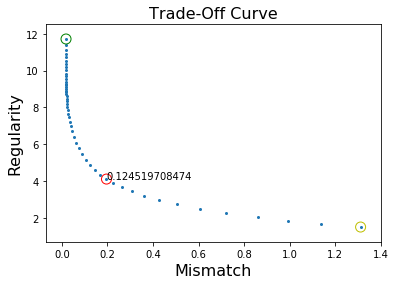

In [18]:
data_error = [res[1] for res in pad_results[:-12]]
reg_error = [res[2] for res in pad_results[:-12]]
lvals = [res[3] for res in pad_results[:-12]]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.scatter( data_error, reg_error,s=4)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

(119.94999999999999, 209.71000000000001)

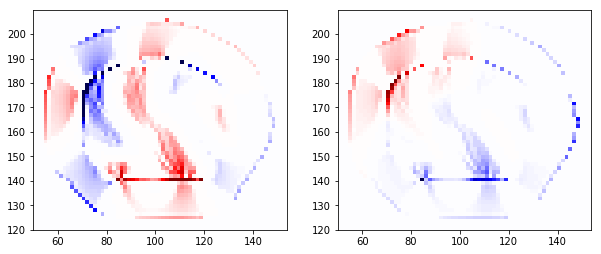

In [19]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[best][0][0][:,0]
s_y[condition_inside] = pad_results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

In [10]:
import pickle
import gzip

with gzip.open('../results/isotropic_L1_synthetic_results_x_expanded.gz','wb') as f:
    pickle.dump(pad_results + [ [x_obs_positions,y_obs_positions]],f)